In [9]:
import pandas as pd

In [12]:
sales_data = pd.read_csv('sales_data_recent_modified.csv')
inventory_data = pd.read_csv('inventory_data.csv')

In [13]:
sales_data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Order ID           10000 non-null  int64  
 1   Date               10000 non-null  object 
 2   SKU                10000 non-null  object 
 3   Units Sold         10000 non-null  int64  
 4   Selling Price      10000 non-null  float64
 5   Total Sales Value  10000 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 468.9+ KB


In [14]:
sales_data.dropna(inplace=True) 

# 2. Calculate Key Metrics

In [15]:
#Calculate the Daily Run Rate for each SKU based on the sales data.
daily_run_rate = sales_data.groupby('SKU')['Units Sold'].sum() / sales_data['Date'].nunique()
print("Daily Run Rate for each SKU:")
print(daily_run_rate)

Daily Run Rate for each SKU:
SKU
SKU0001    2.409836
SKU0002    2.770492
SKU0003    2.393443
SKU0004    2.590164
SKU0005    2.950820
             ...   
SKU0096    2.262295
SKU0097    2.180328
SKU0098    2.573770
SKU0099    2.131148
SKU0100    2.622951
Name: Units Sold, Length: 100, dtype: float64


In [16]:
#Compute the Days on Hand (DOH) for each SKU
inventory_data['Daily Run Rate'] = inventory_data['SKU'].map(daily_run_rate)
inventory_data['DOH'] = inventory_data['Stock Level'] / inventory_data['Daily Run Rate']
print(inventory_data[['SKU', 'Stock Level', 'Daily Run Rate', 'DOH']])

          SKU  Stock Level  Daily Run Rate         DOH
0     SKU0001          228        2.409836   94.612245
1     SKU0001          374        2.409836  155.197279
2     SKU0001          426        2.409836  176.775510
3     SKU0001          267        2.409836  110.795918
4     SKU0001          111        2.409836   46.061224
...       ...          ...             ...         ...
2995  SKU0100          217        2.622951   82.731250
2996  SKU0100          159        2.622951   60.618750
2997  SKU0100          325        2.622951  123.906250
2998  SKU0100          243        2.622951   92.643750
2999  SKU0100          252        2.622951   96.075000

[3000 rows x 4 columns]


# 3. SKU Performance Analysis

In [17]:
#Categorize SKUs into Best Sellers, Mid Sellers, and Low Sellers using their total sales
total_sales = sales_data.groupby('SKU')['Total Sales Value'].sum()
quantiles = total_sales.quantile([0.2, 0.8])
low = total_sales.quantile(0.2)  
high = total_sales.quantile(0.8) 

def categorize_sku(value):
    if value < low:
        return "Low Seller"
    elif value < high:
        return "Mid Seller"
    else:
        return "Best Seller"

sku_categories = total_sales.apply(categorize_sku)
print("SKU Performance Categories:")
print(sku_categories)

SKU Performance Categories:
SKU
SKU0001    Best Seller
SKU0002    Best Seller
SKU0003     Mid Seller
SKU0004     Mid Seller
SKU0005    Best Seller
              ...     
SKU0096     Mid Seller
SKU0097     Mid Seller
SKU0098     Mid Seller
SKU0099     Low Seller
SKU0100     Mid Seller
Name: Total Sales Value, Length: 100, dtype: object


# 4. Stock Reorder Recommendations

In [18]:
#Identify which SKUs need to be reordered by comparing the current stock level with the reorder level.
reorder = inventory_data[inventory_data['Stock Level'] < inventory_data['Reorder Level']]
reorder['Reorder Quantity'] = reorder['Reorder Level'] - reorder['Stock Level']
print("Reorder Recommendations:")
print(reorder[['SKU', 'Stock Level', 'Reorder Level', 'Reorder Quantity']])

Reorder Recommendations:
          SKU  Stock Level  Reorder Level  Reorder Quantity
9     SKU0001           51             92                41
17    SKU0001           20             52                32
19    SKU0001           55             79                24
29    SKU0001            7            104                97
32    SKU0002          100            133                33
...       ...          ...            ...               ...
2962  SKU0099            9            147               138
2968  SKU0099           12             75                63
2980  SKU0100           58            123                65
2985  SKU0100           28            127                99
2989  SKU0100           67             72                 5

[611 rows x 4 columns]


C:\Users\Kalpesh\AppData\Local\Temp\ipykernel_27052\3927383443.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reorder['Reorder Quantity'] = reorder['Reorder Level'] - reorder['Stock Level']


# 5. Price Sensitivity Analysis

In [19]:
#Analyze how the selling price impacts the number of units sold.
# Group sales data by SKU to analyze price sensitivity
price_units_corr = sales_data.groupby('SKU').apply(
    lambda x: x['Selling Price'].corr(x['Units Sold'])
)

# Display SKUs with their price sensitivity (correlation values)
print("Price Sensitivity (Correlation between Selling Price and Units Sold):")
print(price_units_corr)

Price Sensitivity (Correlation between Selling Price and Units Sold):
SKU
SKU0001    0.087245
SKU0002    0.007965
SKU0003   -0.002884
SKU0004   -0.035854
SKU0005   -0.040334
             ...   
SKU0096   -0.150265
SKU0097    0.001032
SKU0098   -0.022661
SKU0099   -0.063166
SKU0100    0.019649
Length: 100, dtype: float64


In [20]:
# Define threshold for high sensitivity
high_sensitivity_threshold = -0.1

# Identify high price-sensitive SKUs
high_sensitive_skus = price_units_corr[price_units_corr < high_sensitivity_threshold]

print("High Price-Sensitive SKUs:")
print(high_sensitive_skus)


High Price-Sensitive SKUs:
SKU
SKU0023   -0.148558
SKU0029   -0.197391
SKU0035   -0.163169
SKU0039   -0.230384
SKU0042   -0.151238
SKU0043   -0.121443
SKU0050   -0.144877
SKU0051   -0.147747
SKU0057   -0.180598
SKU0058   -0.127914
SKU0060   -0.100598
SKU0063   -0.170956
SKU0064   -0.104462
SKU0076   -0.164399
SKU0078   -0.205046
SKU0084   -0.139460
SKU0085   -0.197212
SKU0096   -0.150265
dtype: float64


In [21]:
#Identify SKUs with high price sensitivity and provide price adjustment recommendations for at least 3 SKUs
for sku in high_sensitive_skus.index:
    avg_price = sales_data[sales_data['SKU'] == sku]['Selling Price'].mean()
    recommendation = avg_price * 0.95  # Suggest a 5% price reduction
    print(f"SKU {sku}: Consider reducing price to {recommendation:.2f} to boost sales.")

SKU SKU0023: Consider reducing price to 52.88 to boost sales.
SKU SKU0029: Consider reducing price to 49.71 to boost sales.
SKU SKU0035: Consider reducing price to 54.42 to boost sales.
SKU SKU0039: Consider reducing price to 51.64 to boost sales.
SKU SKU0042: Consider reducing price to 51.64 to boost sales.
SKU SKU0043: Consider reducing price to 52.08 to boost sales.
SKU SKU0050: Consider reducing price to 51.06 to boost sales.
SKU SKU0051: Consider reducing price to 55.02 to boost sales.
SKU SKU0057: Consider reducing price to 51.88 to boost sales.
SKU SKU0058: Consider reducing price to 52.85 to boost sales.
SKU SKU0060: Consider reducing price to 52.62 to boost sales.
SKU SKU0063: Consider reducing price to 50.41 to boost sales.
SKU SKU0064: Consider reducing price to 49.78 to boost sales.
SKU SKU0076: Consider reducing price to 53.30 to boost sales.
SKU SKU0078: Consider reducing price to 48.93 to boost sales.
SKU SKU0084: Consider reducing price to 49.28 to boost sales.
SKU SKU0

# 6.Visualizations

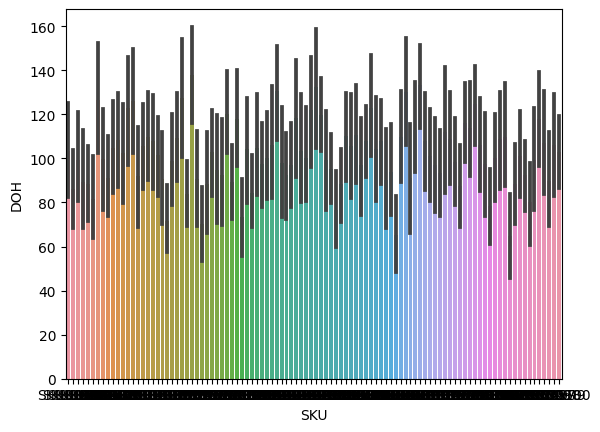

In [24]:
#Create relevant charts to display key findings
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='SKU', y='DOH', data=inventory_data)
plt.show()

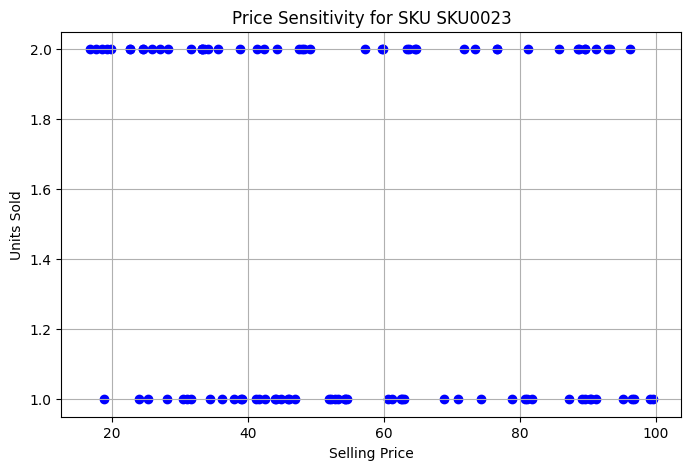

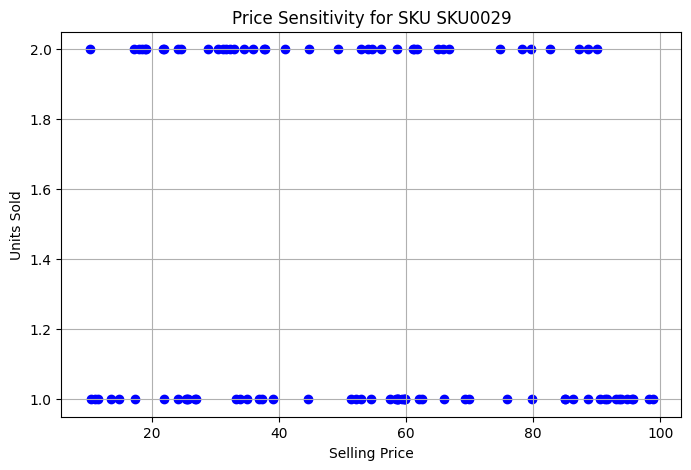

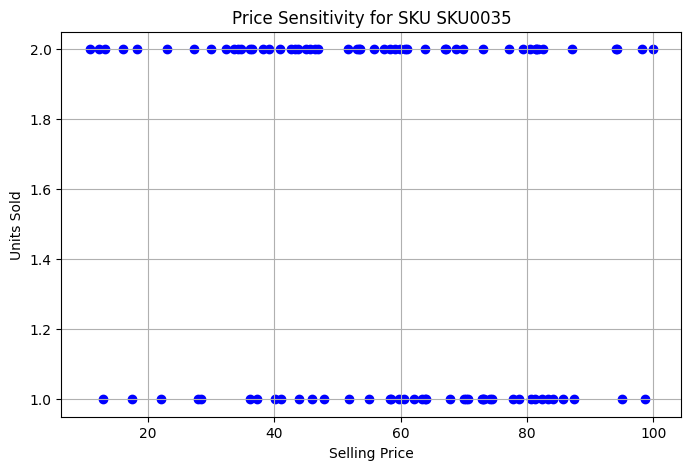

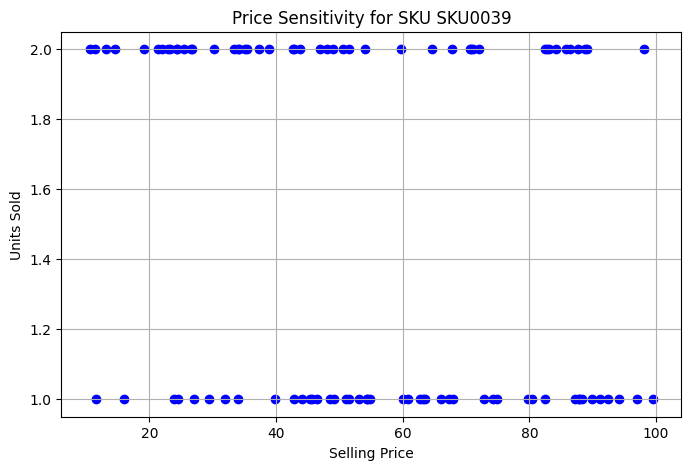

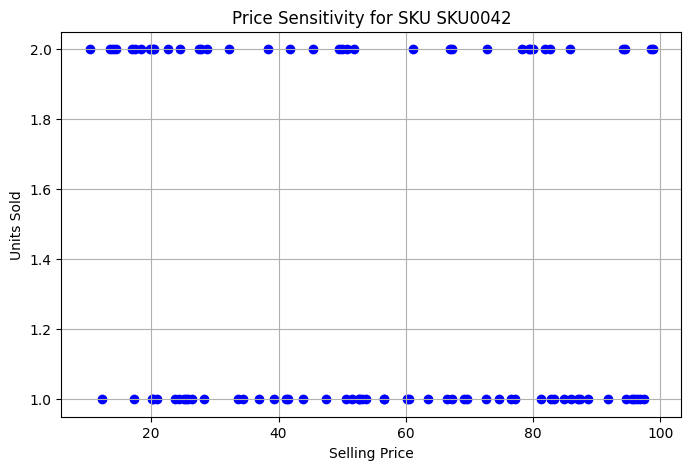

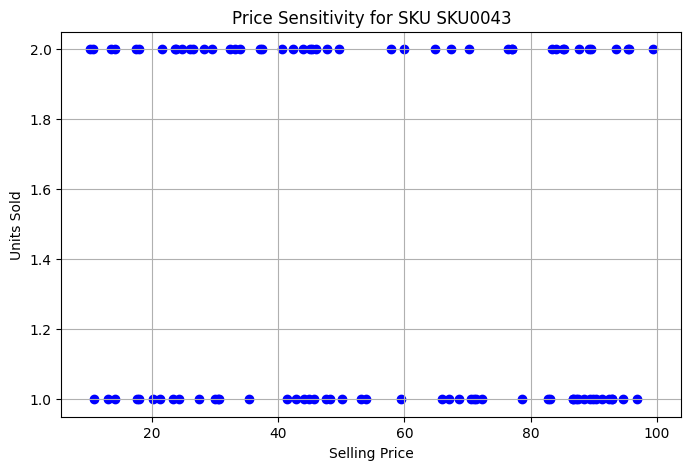

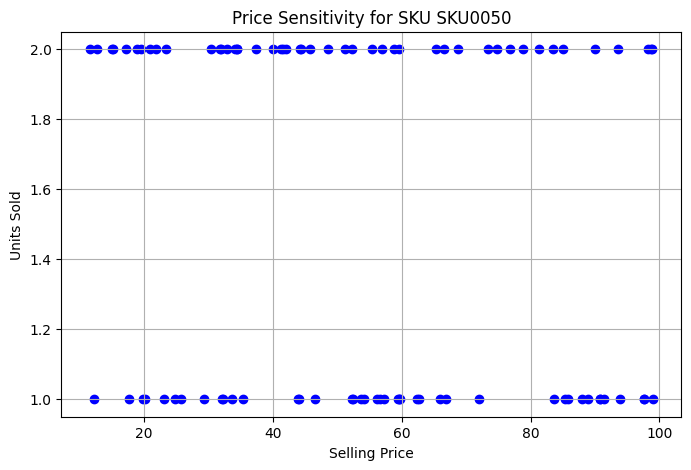

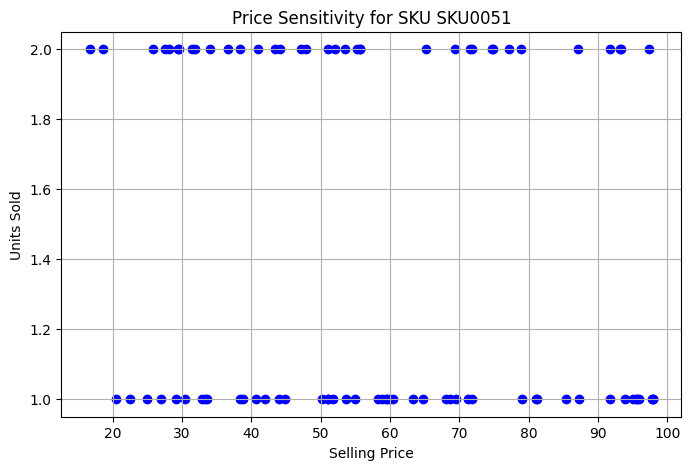

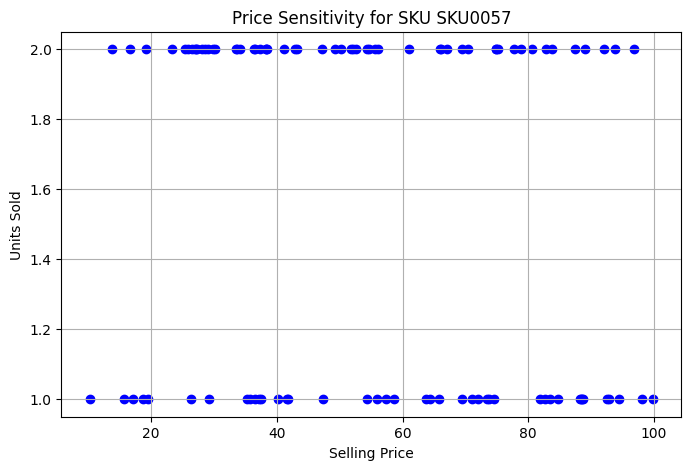

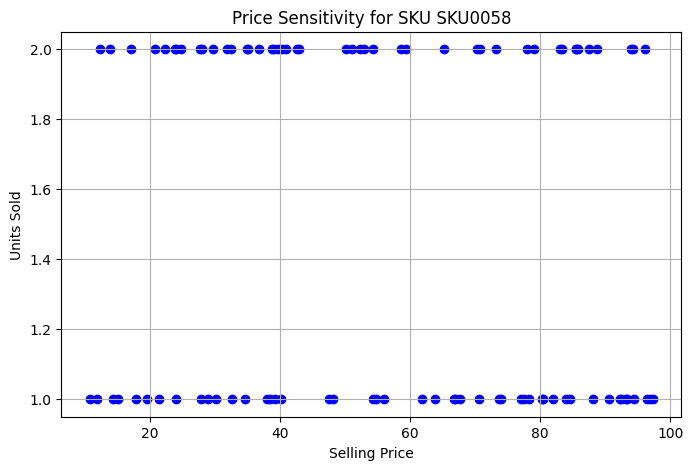

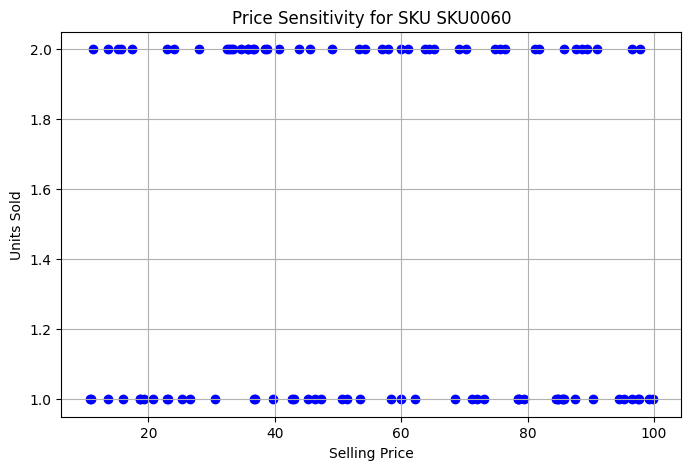

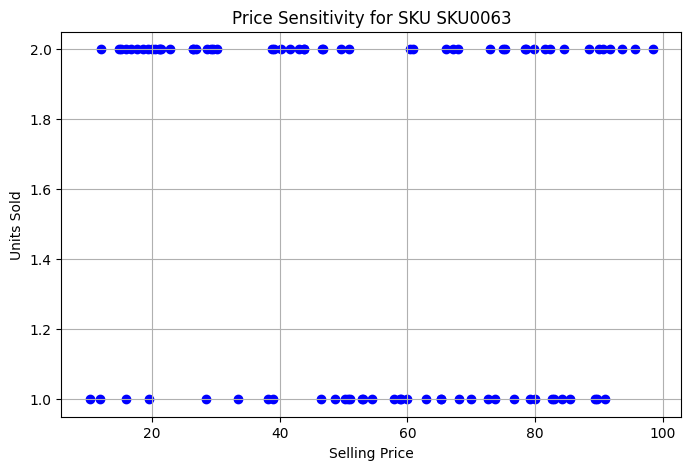

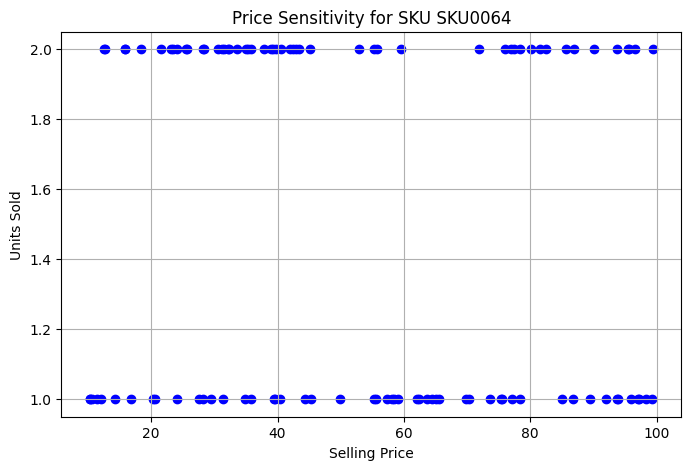

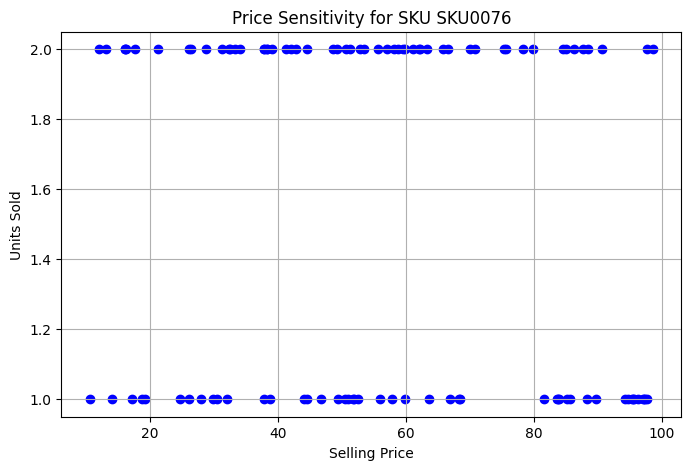

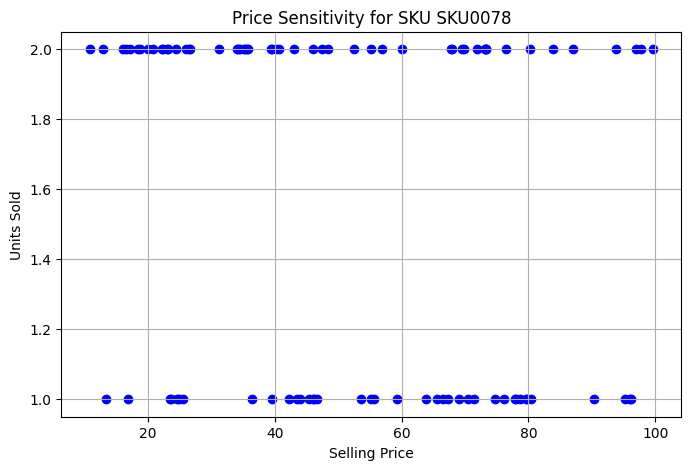

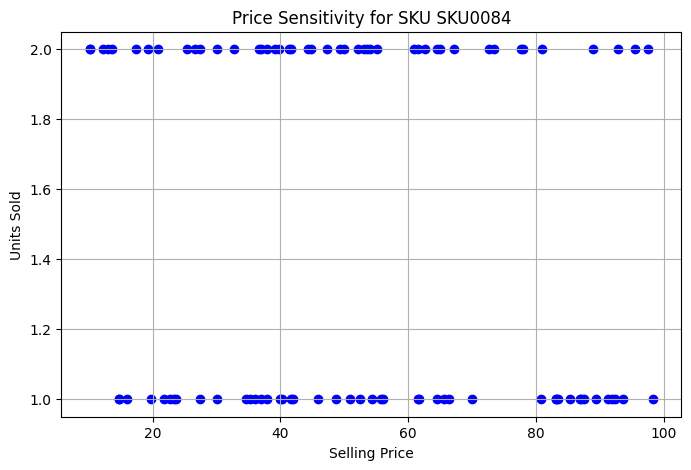

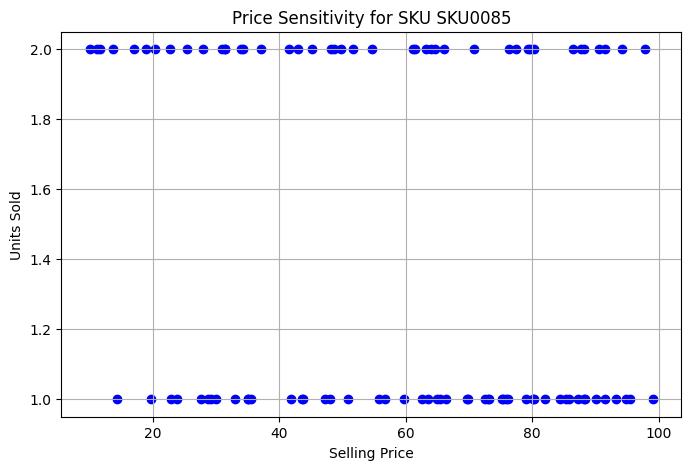

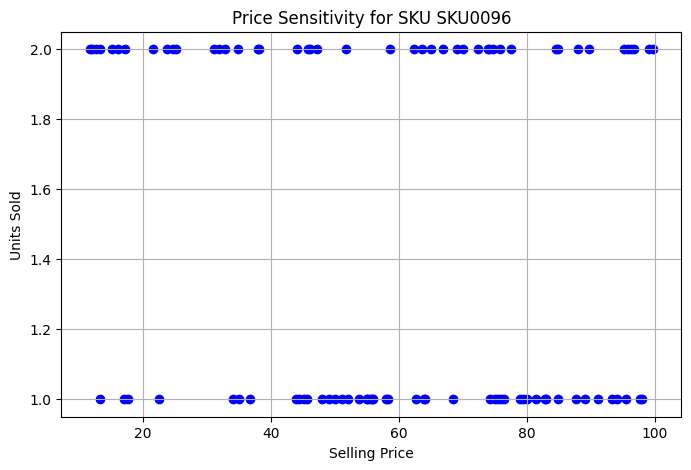

In [25]:
# Plot Selling Price vs Units Sold for high-sensitive SKUs
for sku in high_sensitive_skus.index:
    sku_data = sales_data[sales_data['SKU'] == sku]
    plt.figure(figsize=(8, 5))
    plt.scatter(sku_data['Selling Price'], sku_data['Units Sold'], color='blue')
    plt.title(f"Price Sensitivity for SKU {sku}")
    plt.xlabel("Selling Price")
    plt.ylabel("Units Sold")
    plt.grid()
    plt.show()
